In [15]:
import os
import tensorflow as tf
import models.unet as unet
from model_util import ImgTester, model_path
from model_util import Saver
from model_util import load_all_imgs

In [16]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [17]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = (64,64)
epochs = 30
batch_size= 32
validation_split= 0.2
f = [16, 32, 64]
threshold = 0.5
metric = [
    tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=threshold),
    tf.keras.metrics.MeanIoU(num_classes=2)
]
base_output_path = '..\\imagens_cra\\result\\unet_acc_iou_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation/cra"


In [18]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)
validImgs = load_all_imgs(y_dir,image_size, 0)


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

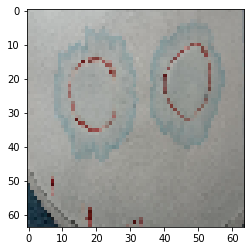

In [19]:
import matplotlib.pyplot as plt
plt.imshow(trainImgs[0])

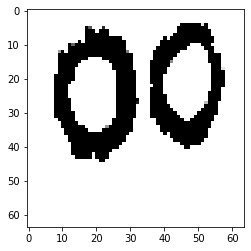

In [20]:
plt.imshow(validImgs[0], cmap=plt.cm.binary)

In [21]:
model = unet.build(image_size, f)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metric])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_17[0][0]                  
______________________________________________________________________________________________

In [22]:
try:
    os.mkdir(base_output_path)
except OSError as error:
  pass

callbacks = tf.keras.callbacks.ModelCheckpoint(
    model_path(base_output_path),
    monitor='binary_accuracy', verbose=0,
    save_best_only=True,
    mode='auto',
    save_freq='epoch',
)
history = model.fit(
    trainImgs, validImgs,
    epochs=epochs,  batch_size=batch_size, callbacks=callbacks,
    validation_split=validation_split,
)

Epoch 1/30
17/17 [==============================] - 8s 165ms/step - loss: 0.5673 - binary_accuracy: 0.8005 - mean_io_u_2: 0.4017 - val_loss: 0.4454 - val_binary_accuracy: 0.8017 - val_mean_io_u_2: 0.4023

saved to: ..\imagens_cra\result\unet_acc_iou_epoch_30_size_(64, 64)\acc_por_epocas


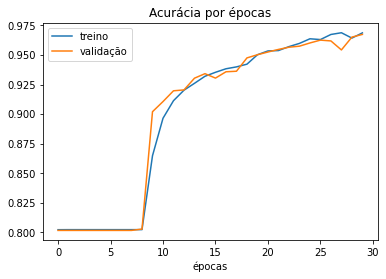

In [23]:
internal_saver = Saver(model, history, base_output_path)
internal_saver.save_metrics("binary_accuracy")

saved to: ..\imagens_cra\result\unet_acc_iou_epoch_30_size_(64, 64)\loss_por_epocas


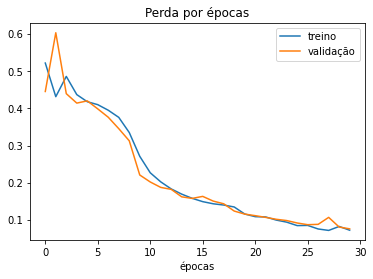

In [24]:
internal_saver.save_loss()

found 659 img to test

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Write metrics to: ..\imagens_cra\result\unet_acc_iou_epoch_30_size_(64, 64)\metrics.csv


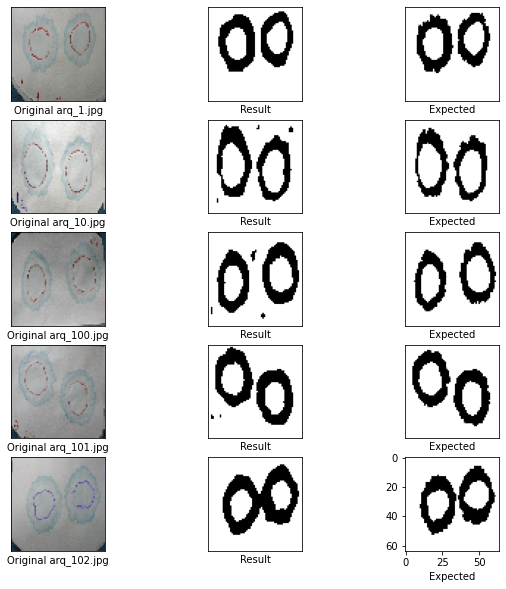

In [25]:
imgTester_metrics = metric
imgTester = ImgTester(base_output_path, x_dir, y_dir, image_size)
imgTester.test(-1, 5, imgTester_metrics, threshold)
